In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [21]:
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath

import wfdb

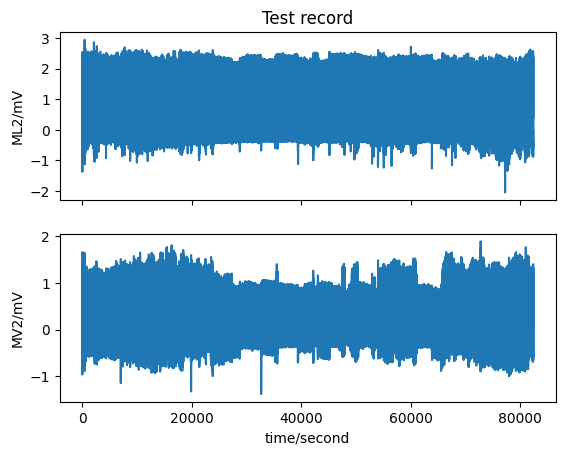

{'record_name': 's20011',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 20594750,
 'base_time': datetime.time(17, 8),
 'base_date': datetime.date(1994, 12, 9),
 'comments': ['Age: 58  Sex: M',
  'Comments:',
  'Lead 0:',
  'All ST change episodes appeared to be rate-related non-ischemic',
  'episodes characterized by J-point depression and scooping of the',
  'ST segment.',
  'Lead 1:',
  'All episodes in lead 1 are compatible with heart-rate induced',
  'non-ischemic changes and are so labeled. It is recognized that',
  'this is an arbitrary decision.',
  'This record is from the initial Long-Term ST Database of',
  'eleven 24-hour ST annotated ambulatory records (record s20689).',
  'Symptoms during Holter recording: None reported',
  'Diagnoses:',
  'No coronary artery disease',
  'Treatment:',
  'Medications: None',
  'Balloon Angioplasty: No',
  'Coronary Artery bypass Grafting: No',
  'History:',
  'ST depressions but no coronary artery diseas

In [3]:
# rdrecord - read entire record
record = wfdb.rdrecord("../data/20011/s20011")
wfdb.plot_wfdb(record, title="Test record")
display(record.__dict__)
record2 = wfdb.rdrecord('a103l', pn_dir='challenge-2015/training/') # from web

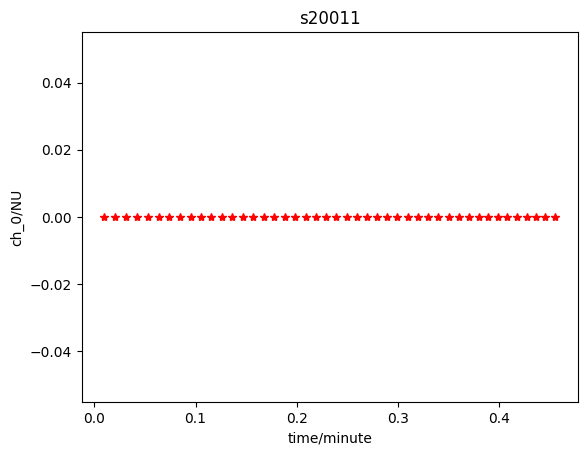

In [4]:
# rdsamp - read a part (sample) of record
signals, fields = wfdb.rdsamp("../data/20011/s20011", sampfrom=0, sampto=10000)
#display(signals)
#display(fields)

# rdheader - read only header
record = wfdb.rdheader("../data/20011/s20011")

# rdann - read annotation file into Annotation object
ann = wfdb.rdann("../data/20011/s20011", "atr", sampfrom=0, sampto=10000)
print(ann)
ann.fs = 360 # sampling frequency
wfdb.plot_wfdb(annotation=ann, time_units="minutes")

In [54]:
# WRITING RECORDS

# wrsamp - write records
# reading and saving part of the challenge-2015 dataset
sig, fields = wfdb.rdsamp('a103l', sampfrom=50000, channels=[0,1], pn_dir='challenge-2015/training')
wfdb.wrsamp('ecg-record', fs=250, units=['mV', 'mV'], sig_name=['I', 'II'], p_signal=sig, fmt=['16', '16'])
record = wfdb.rdrecord('ecg-record')

#multi sample rates: expanded=True

# wrann - write annotations
annotation = wfdb.rdann('b001', 'atr', pn_dir='cebsdb')
wfdb.wrann('b001', 'cpy', annotation.sample, annotation.symbol)

wfdb.show_ann_labels() # standardized WFDB annot. labels

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [49]:
# DOWNLOADING DATABASES (instead of streaming)

#display(wfdb.get_dbs()) #list available

# Download all the WFDB content
dl_dir = "dl_db"
wfdb.dl_database('ahadb', dl_dir=dl_dir)
display(os.listdir(dl_dir))

Generating record list for: 0001
Generating record list for: 0201
Generating list of all files for: 0001
Generating list of all files for: 0201
Finished downloading files


['0001.atr', '0001.dat', '0001.hea', '0201.atr', '0201.dat', '0201.hea']

C:\Users\Matej\AppData\Local\Temp\ipykernel_15864\1028363942.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',
C:\Users\Matej\AppData\Local\Temp\ipykernel_15864\1028363942.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',


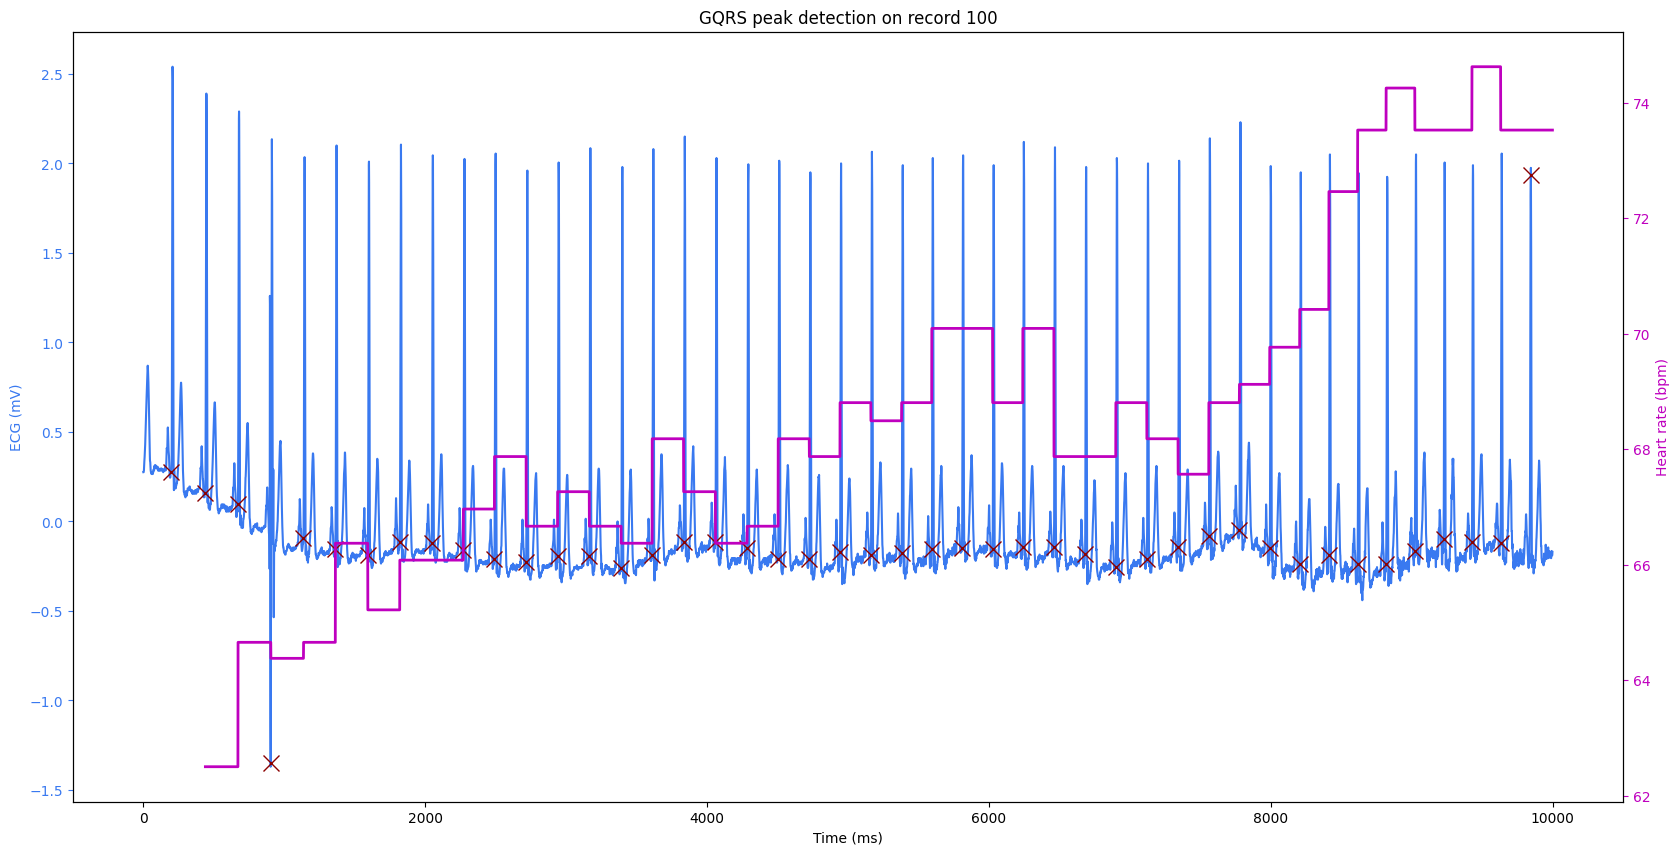

In [50]:
# ECG processing

import wfdb
from wfdb import processing


# Demo 19 - Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()
    
    
# Load the WFDB record and the physical samples
record = wfdb.rdrecord("../data/20011/s20011", sampfrom=0, sampto=10000, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record 100")


Corrected GQRS detected peak indices: [207, 447, 679, 912, 1144, 1371, 1601, 1828, 2054, 2279, 2500, 2725, 2947, 3172, 3399, 3619, 3842, 4067, 4293, 4512, 4733, 4951, 5170, 5389, 5602, 5817, 6034, 6248, 6469, 6690, 6908, 7129, 7350, 7568, 7785, 8000, 8213, 8420, 8625, 8826, 9031, 9234, 9435, 9639, 9846]


C:\Users\Matej\AppData\Local\Temp\ipykernel_15864\1028363942.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',
C:\Users\Matej\AppData\Local\Temp\ipykernel_15864\1028363942.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',


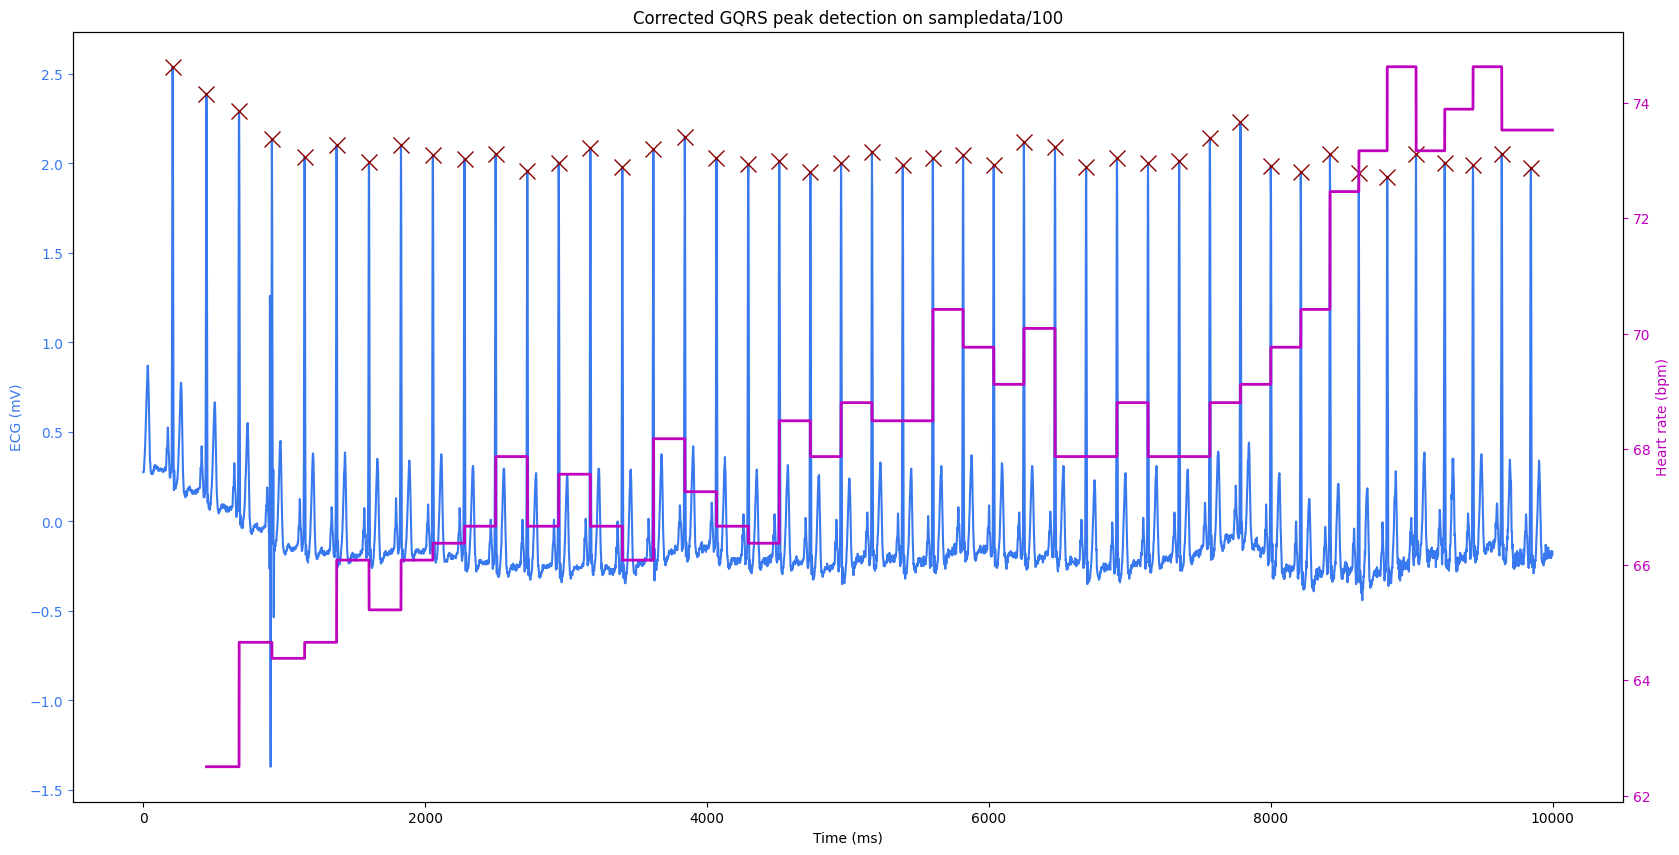

In [44]:
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on sampledata/100")
    

In [5]:
help(wfdb.Annotation) 


Help on class Annotation in module wfdb.io.annotation:

class Annotation(builtins.object)
 |  Annotation(record_name, extension, sample, symbol=None, subtype=None, chan=None, num=None, aux_note=None, fs=None, label_store=None, description=None, custom_labels=None, contained_labels=None)
 |  
 |  The class representing WFDB annotations.
 |  
 |  Annotation objects can be created using the initializer, or by reading a
 |  WFDB annotation file with `rdann`.
 |  
 |  The attributes of the Annotation object give information about the
 |  annotation as specified by:
 |  https://www.physionet.org/physiotools/wag/annot-5.htm
 |  
 |  Call `show_ann_labels()` to see the list of standard annotation codes. Any
 |  text used to label annotations that are not one of these codes should go in
 |  the 'aux_note' field rather than the 'sym' field.
 |  
 |  The current annotation values organized as such:
 |  
 |      AnnotationLabel(label_store (or subtype), symbol (or aux_note), short_description, des

250
[ 208  448  680  912 1144 1372 1602 1828 2054 2278 2500 2724 2948 3172
 3398 3618 3842 4068 4292 4512 4734 4950 5170 5388 5602 5816 6034 6248
 6468 6690 6908 7128 7350 7568 7784 8000 8212 8420 8624 8826 9030 9234
 9434 9638 9844]
[ 208  448  680  912 1144 1372 1602 1828 2054 2278 2500 2724 2948 3172
 3398 3618 3842 4068 4292 4512 4734 4950 5170 5388 5602 5816 6034 6248
 6468 6690 6908 7128 7350 7568 7784 8000 8212 8420 8624 8826 9030 9234
 9434 9638 9844]


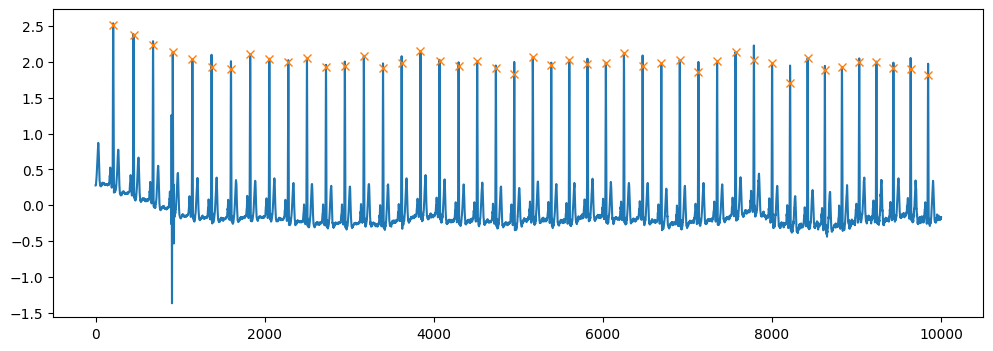

In [25]:
# annotation = wfdb.rdann('b001', 'atr', pn_dir='cebsdb' , sampto=100000)
# record = wfdb.rdrecord('b001', pn_dir='cebsdb', sampto=100000)

annotation = wfdb.rdann("../data/20011/s20011", 'atr' , sampto=10000)
record = wfdb.rdrecord("../data/20011/s20011", sampto=10000)

fs = record.fs
print(fs)
sig = record.p_signal[:, 0]

anx = annotation.sample[:]
print(anx)
antype = annotation.symbol[:]

print(annotation.sample[:100])

figsize(12, 4)
plt.plot(sig)
plt.plot(anx, sig[anx], "x")